In [2]:
import kagglehub
import pandas as pd
import os
from PIL import Image
import numpy as np
import torch 
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import matplotlib.pyplot as plt
import seaborn as sns



# EDA


In [3]:
# Download latest version
path = kagglehub.dataset_download("gpreda/chinese-mnist")

print("Path to dataset files:", path)

# Load the dataset into a pandas DataFrame
csv_file_path = f"{path}/chinese_mnist.csv"
dataDF = pd.read_csv(csv_file_path)


# Print the feature names (column names)
print("Feature names:", dataDF.columns.tolist())

Path to dataset files: C:\Users\angel\.cache\kagglehub\datasets\gpreda\chinese-mnist\versions\7
Feature names: ['suite_id', 'sample_id', 'code', 'value', 'character']


In [4]:
IMAGE_PATH = f"{path}/data/data/"
print("image files :", len(os.listdir(IMAGE_PATH)))

# Add file name to the data frame
dataDF['file'] = dataDF[['suite_id','sample_id','code']].apply(lambda x: 'input_' + 
                 x['suite_id'].astype(str) +'_'+x['sample_id'].astype(str)+'_'+x['code'].astype(str)+'.jpg', axis=1)
dataDF.head(5)

# Characters list
characters = dataDF['character'].unique().tolist()
print(characters)
print(len(characters))



image files : 15000
['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
15


In [5]:
indexImage = 3000
imgPath =  os.path.join(IMAGE_PATH, dataDF['file'][indexImage]) 
im = Image.open(imgPath)
im.size
IMG_SIZE = im.size[0]

# Data Preparation

In [6]:
class ChineseMNISTdataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir):
        self.df = annotations_dataframe
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imgPath =  os.path.join(self.img_dir, self.df ['file'][idx]) 
        img = Image.open(imgPath)

        imgAsT = torch.from_numpy(np.array(img)).float()

        label = self.df['code'][idx] -1 # let's use the code as target variable
        
        return imgAsT, label

In [7]:
chineseNumbers = ChineseMNISTdataset(dataDF, IMAGE_PATH)  # init
chineseNumbers.__len__() # dataset length

15000

torch.Size([64, 64])
9
15000


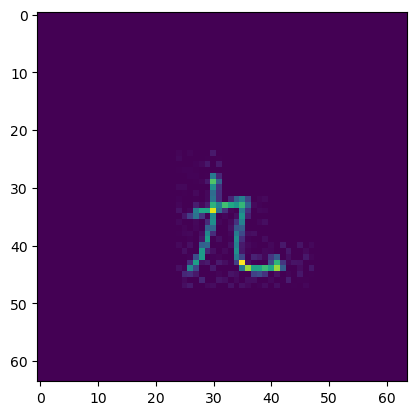

In [8]:
img, label = chineseNumbers.__getitem__(42)
print(img.shape)
print(label)
plt.imshow(img)
print(len(chineseNumbers))


# Split data for training and testing

In [9]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [10]:
testSize = chineseNumbers.__len__() // 10
trainSize = chineseNumbers.__len__() - testSize

trainDataset, testDataset = random_split(chineseNumbers, [trainSize, testSize])

len(trainDataset), len(testDataset)

(13500, 1500)

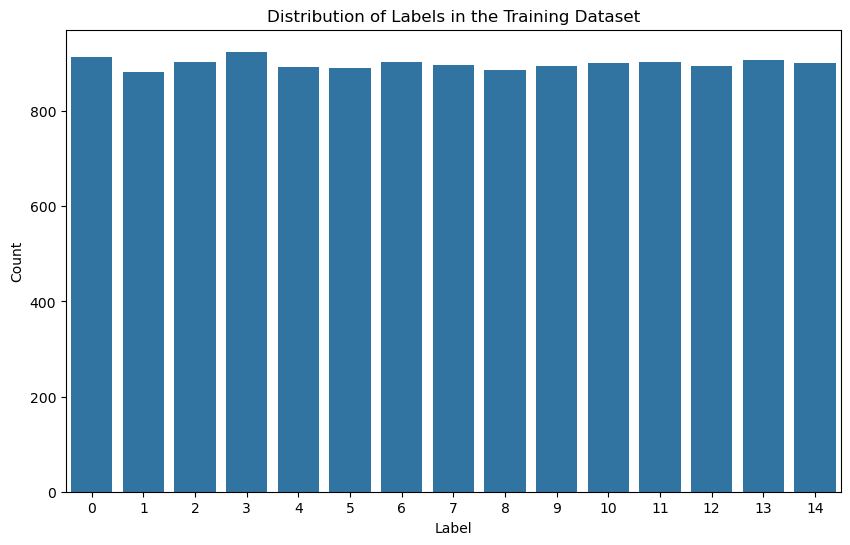

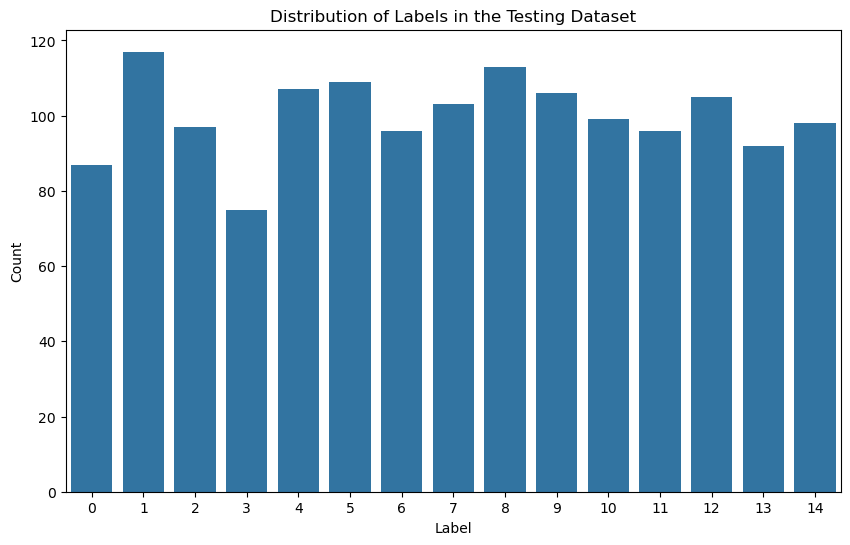

In [11]:
# Extract labels from the training dataset
train_labels = [trainDataset[i][1] for i in range(len(trainDataset))]

# Convert training labels to a pandas DataFrame
train_labels_df = pd.DataFrame(train_labels, columns=['label'])

# Extract labels from the testing dataset
test_labels = [testDataset[i][1] for i in range(len(testDataset))]

# Convert testing labels to a pandas DataFrame
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

# Visualize the distribution of the labels for the training dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_labels_df)
plt.title('Distribution of Labels in the Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of the labels for the testing dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=test_labels_df)
plt.title('Distribution of Labels in the Testing Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [14]:
import matplotlib.pyplot as plt
from matplotlib import font_manager


plt.rcParams['font.sans-serif'] = ['SimHei']  # Set SimHei for Chinese
plt.rcParams['axes.unicode_minus'] = False    # Ensure minus signs are displayed correctly


labels_dict = {
    0: "零", 1: "一", 2: "二", 3: "三", 4: "四", 5: "五",
    6: "六", 7: "七", 8: "八", 9: "九", 10: "十",
    11: "百", 12: "千", 13: "万", 14: "亿"
}


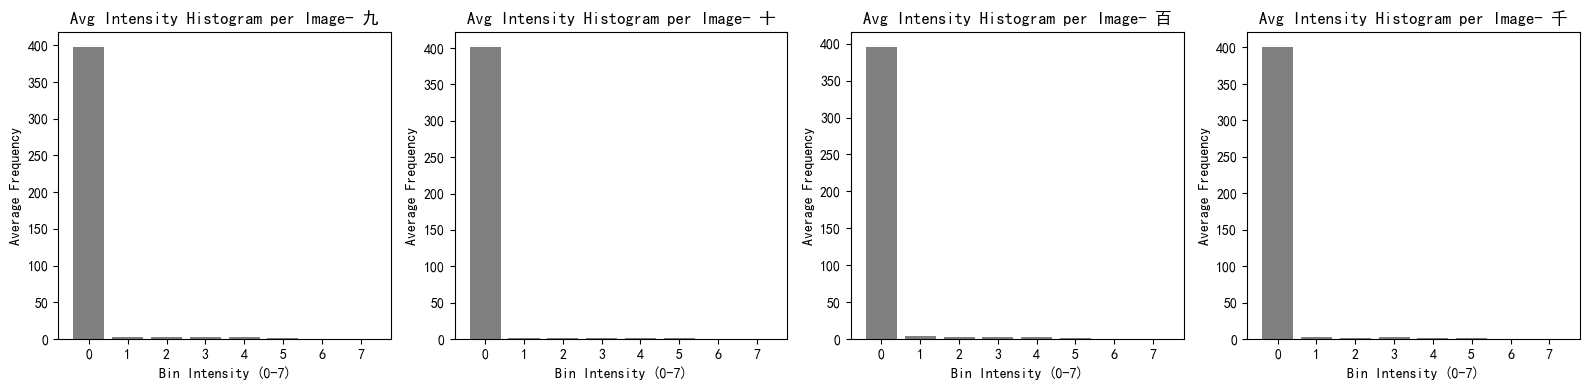

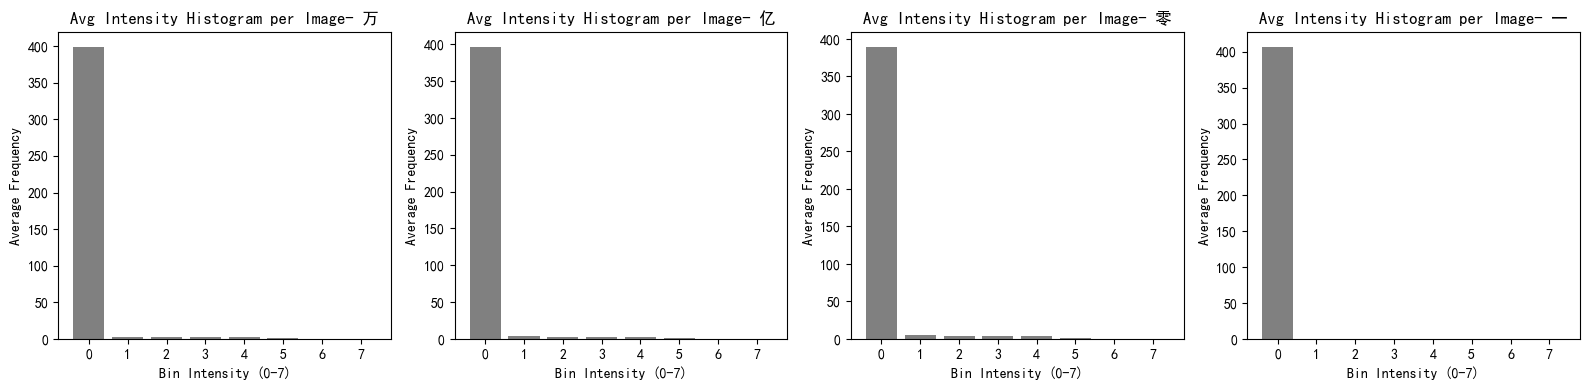

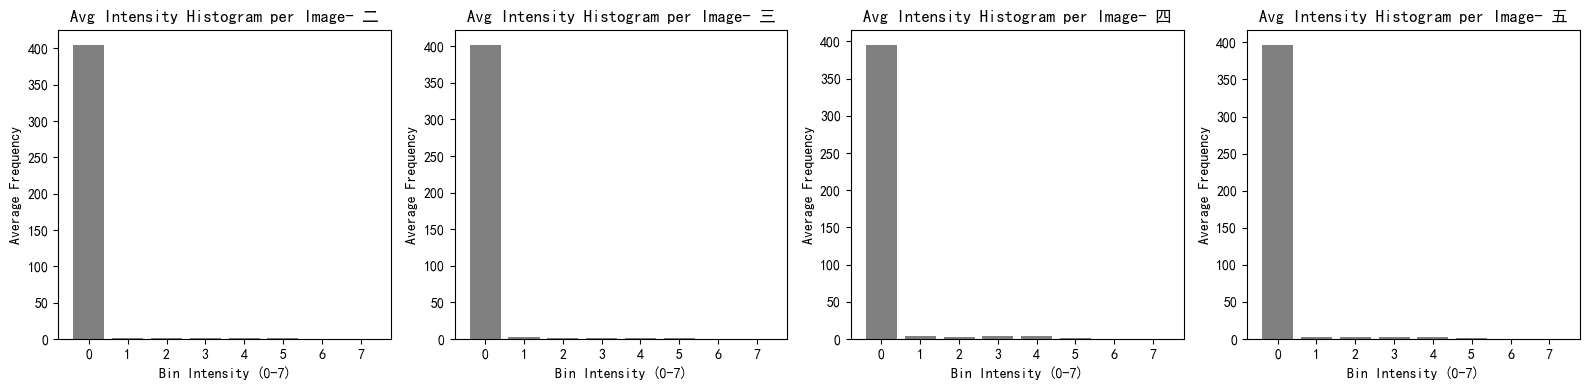

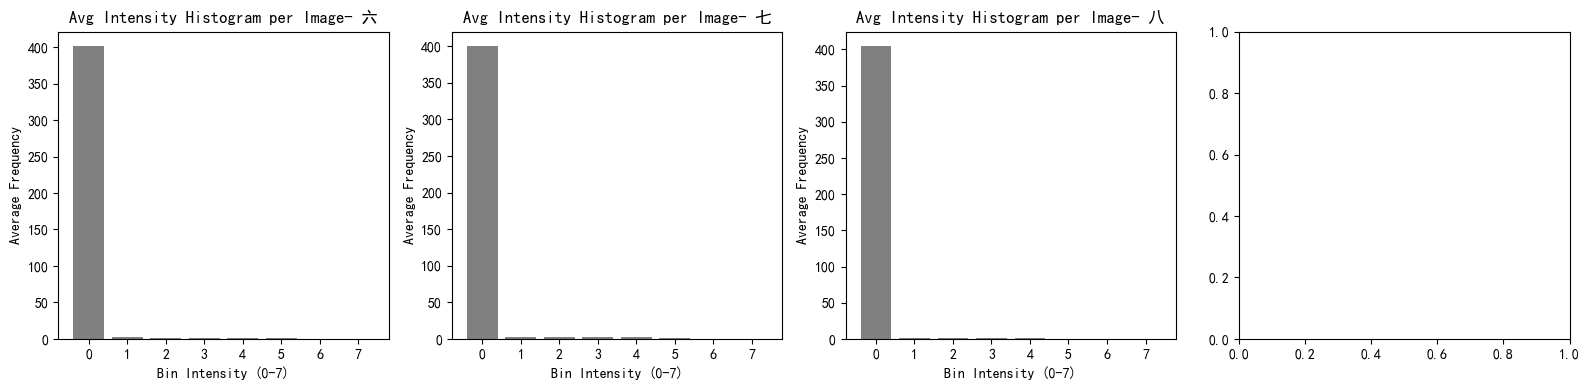

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Number of histograms per row
num_per_row = 4

for i in range(0, 15000, 1000):
    avg_pixel_intensity = np.zeros(8)
    
    for j in range(i, i + 10):
        img, label = chineseNumbers.__getitem__(j)  
        
        img_array = img.flatten()  # Flatten to ensure 1D array for calculations
        
        # Calculate the histogram with 8 bins over the full range of 0 to 255
        hist, _ = np.histogram(img_array, bins=8, range=(0, 256))
        avg_pixel_intensity += hist / 10  # Normalize by the number of pixels in the image
    
    avg_pixel_intensity /= 10  # Average over the 10 images
    
    # Calculate row and column for the current histogram
    index = i // 1000  # Determine the position in the grid
    row = index // num_per_row
    col = index % num_per_row

    # Create a grid of subplots
    if index % num_per_row == 0:
        fig, axs = plt.subplots(1, num_per_row, figsize=(16, 4))  # Adjust figure size for each row

    # Plot the average pixel intensity histogram for this batch of 10 images
    ax = axs[col]
    ax.bar(range(8), avg_pixel_intensity, color='gray', tick_label=range(8)) 
    ax.set_xlabel('Bin Intensity (0-7)')
    ax.set_ylabel('Average Frequency')
    ax.set_title(f'Avg Intensity Histogram per Image- {labels_dict[label]}')

    # Finalize the grid layout at the end of a row
    if index % num_per_row == num_per_row - 1 or i + 1000 >= 15000:
        plt.tight_layout()
        plt.show()


## Sharpness and Edge Detection
- **Objective**: To detect inconsistencies in stroke sharpness and identify blurry or low-quality scans.
- **How**: Apply edge detection filters (such as Sobel or Canny) across a random subset of images. Calculate edge sharpness metrics, and examine if there’s a wide variance in edge clarity.
- **Outcome**: Reveals if any images may need filtering or quality adjustments to standardize sharpness, ensuring the model doesn’t learn unintended noise.

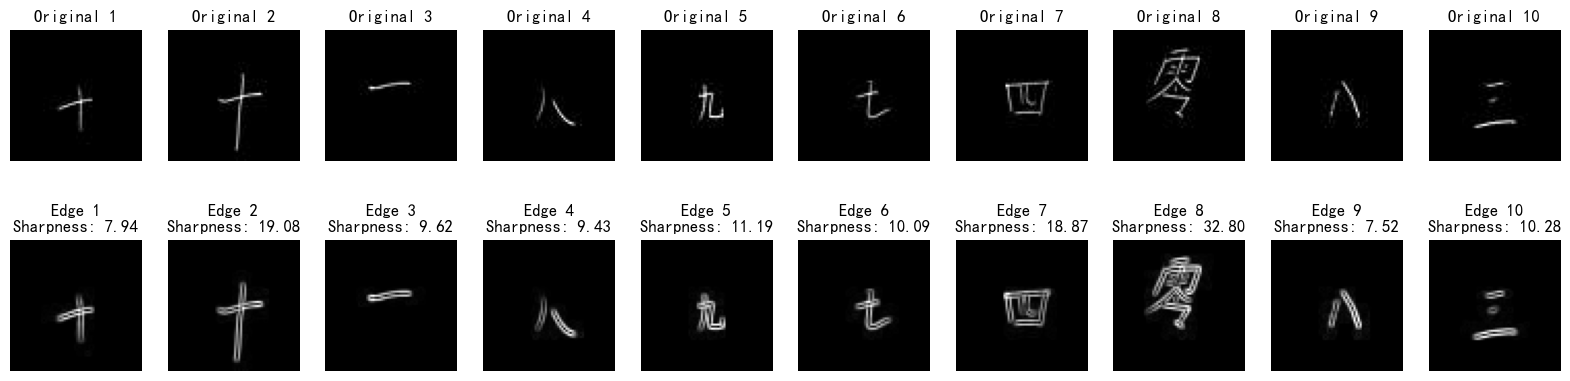

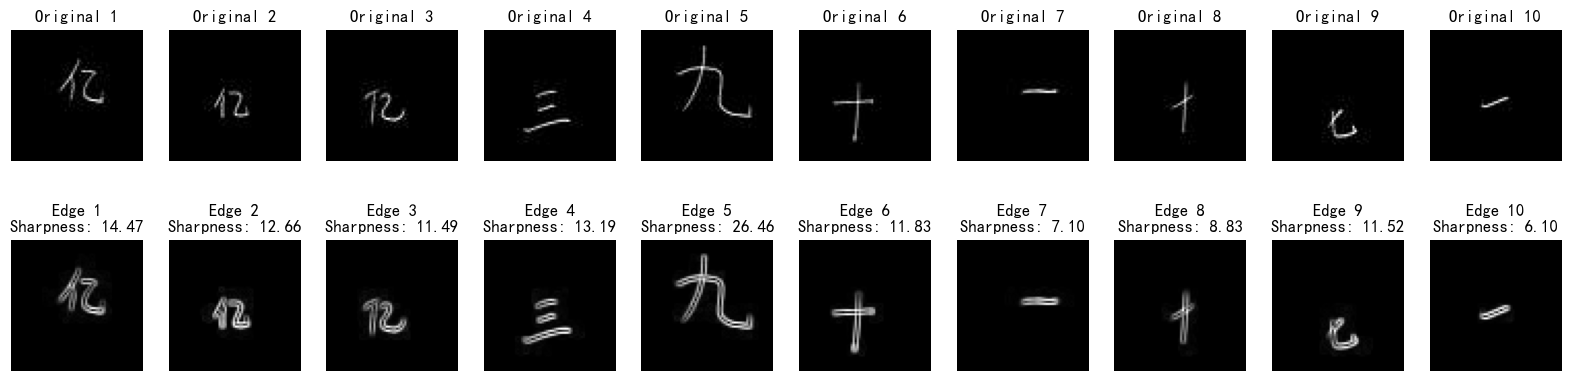

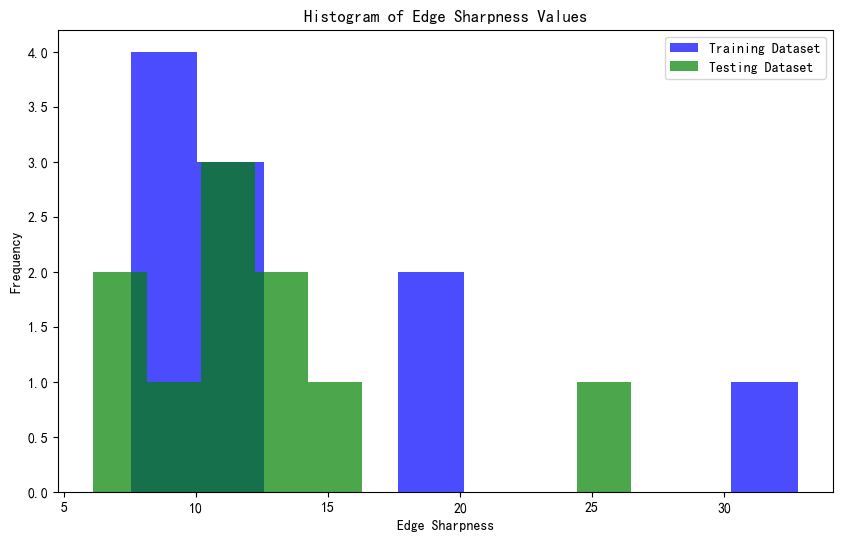

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from torch.utils.data import DataLoader

# Function to apply Sobel filter and calculate edge sharpness
def calculate_edge_sharpness(image):
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    edge_magnitude = np.hypot(sobel_x, sobel_y)
    return np.mean(edge_magnitude)

# Function to visualize edge detection on a random subset of images
def visualize_edge_detection(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    
    sharpness_values = []
    
    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        img_np = img.numpy()
        
        # Calculate edge sharpness
        sharpness = calculate_edge_sharpness(img_np)
        sharpness_values.append(sharpness)
        
        # Plot original image
        axes[0, i].imshow(img_np, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        # Plot edge detection result
        sobel_x = sobel(img_np, axis=0)
        sobel_y = sobel(img_np, axis=1)
        edge_magnitude = np.hypot(sobel_x, sobel_y)
        axes[1, i].imshow(edge_magnitude, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Edge {i+1}\nSharpness: {sharpness:.2f}')
    
    plt.show()
    
    return sharpness_values

# Visualize edge detection on a random subset of training images
train_sharpness_values = visualize_edge_detection(trainDataset)

# Visualize edge detection on a random subset of testing images
test_sharpness_values = visualize_edge_detection(testDataset)

# Plot histogram of sharpness values for training and testing datasets
plt.figure(figsize=(10, 6))
plt.hist(train_sharpness_values, bins=10, color='blue', alpha=0.7, label='Training Dataset')
plt.hist(test_sharpness_values, bins=10, color='green', alpha=0.7, label='Testing Dataset')
plt.title('Histogram of Edge Sharpness Values')
plt.xlabel('Edge Sharpness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Intra-Character Consistency Check
- **Objective**: To examine the consistency of each character’s appearance across different samples and volunteers.
- **How**: Calculate the mean and standard deviation of pixel intensities for each character across all samples, visualizing the range to observe consistency. You might also create "mean" images for each character by averaging pixel values across all samples of a character.
- **Outcome**: This shows the typical appearance of each character and helps in understanding how much variation exists within the same character, which is useful for designing augmentations.

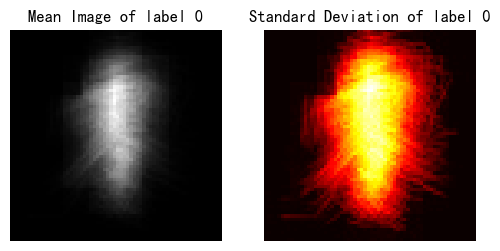

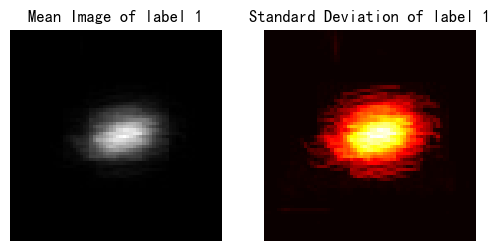

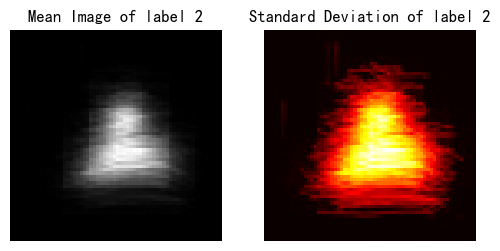

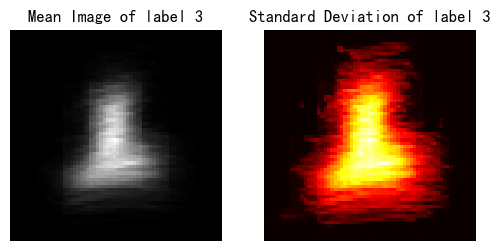

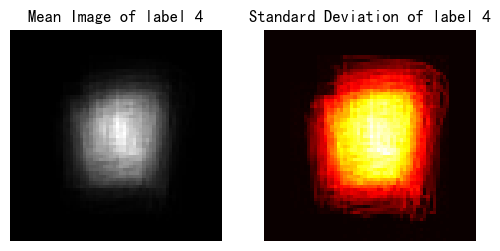

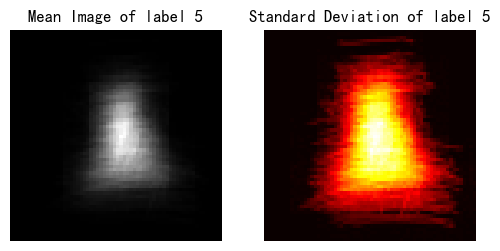

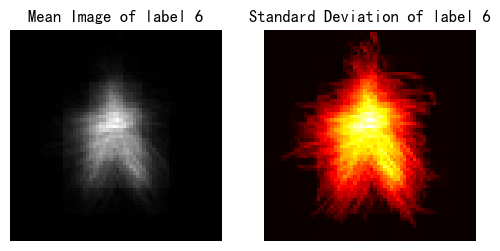

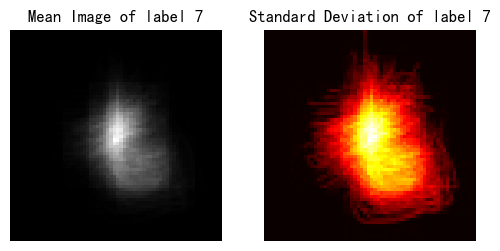

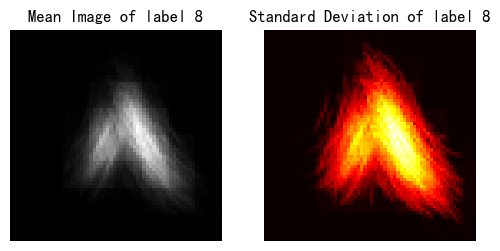

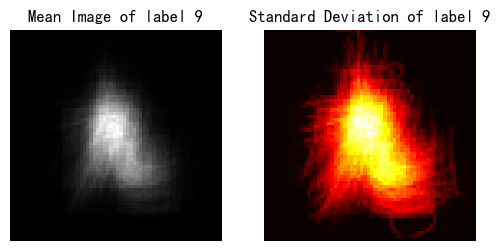

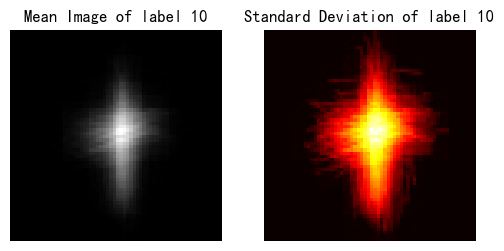

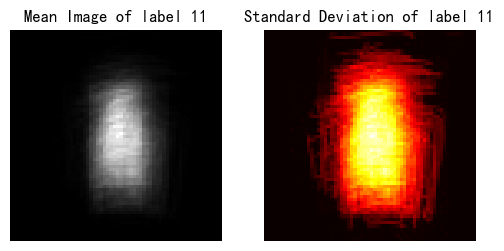

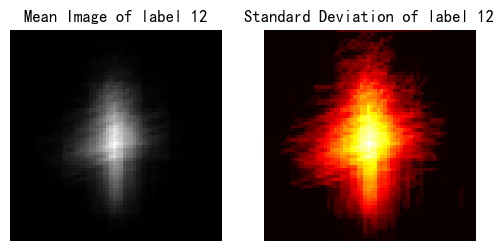

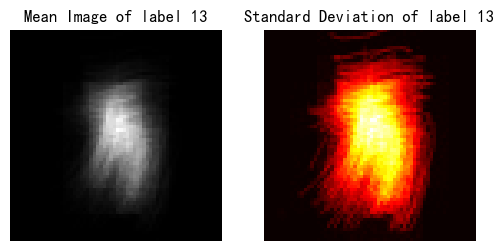

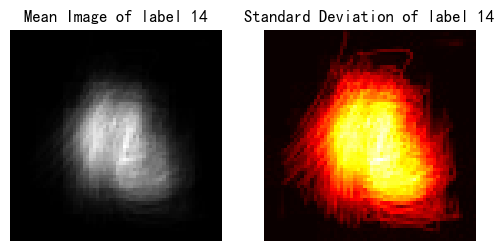

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

mean_images = []
st_dev_images = []
titles = []

# Loop through each character in the dataset
for character in range(len(characters)):
    character_img = []

# Gather all images for the character in training dataset
    for i in range(len(trainDataset)):
        img, label = trainDataset[i]
        if label == character:
            character_img.append(img.numpy())

    # Skip if no images found for this character
    if len(character_img) == 0:
        print(f"No images found for character {character}")
        continue

    # Convert list of images to 3D numpy array (num_samples, height, width)
    character_img = np.array(character_img)

    # Calculate mean and standard deviation across the sample dimension
    mean_image = np.mean(character_img, axis=0)
    st_dev_image = np.std(character_img, axis=0)

    # Save mean and std images for this character and titles for each
    mean_images.append(mean_image)
    st_dev_images.append(st_dev_image)
    titles.append(f"{character} Mean")
    titles.append(f"{character} Std Dev")


# Plot all images in a grid
num_images = len(mean_images) + len(st_dev_images)
cols = 8  # Grid dimensions
rows = (num_images + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.ravel()

# Check axes for all images
for i, ax in enumerate(axes):
    if i < len(titles):
        if i % 2 == 0:
            ax.imshow(mean_images[i // 2], cmap='gray')
        else:
            ax.imshow(st_dev_images[i // 2], cmap='hot')
        ax.set_title(titles[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused axes

plt.tight_layout()
plt.show()

# Augmentation Preview for Quality Assurance

- **Objective**: To assess the effect of augmentations on image quality and character integrity.
- **How**: Apply planned augmentations (rotations, scaling, translations) on a sample set of images and visually inspect them in a grid format for each character.
- **Outcome**: Ensures that augmentations preserve the integrity of each character, helping validate that these transformations won’t create distortions or unnatural examples for the model.


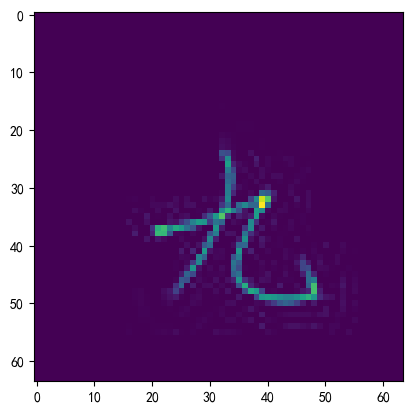

In [25]:
img, label = chineseNumbers.__getitem__(123)
plt.imshow(img)

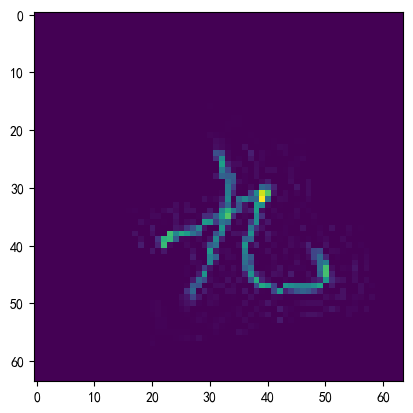

In [27]:
# demonstration of random rotation on single image
import numpy as np
from PIL import Image
import os
import random
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


img, label = chineseNumbers.__getitem__(123)
plt.imshow(img)
img_pil = Image.fromarray(img.numpy().astype(np.uint8))
random_rotation = transforms.RandomRotation(degrees=(-30, 30))
rotated_img = random_rotation(img_pil)
plt.imshow(rotated_img)

27000
3000


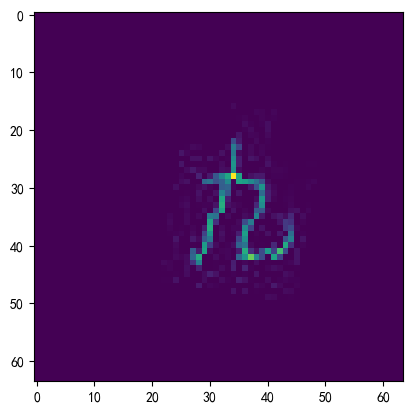

In [28]:
# perform random rotation on each image in train/test dataset, add rotated image to dataset

class AugmentedDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

augmented_images_train = []
augmented_labels_train = []
augmented_images_test = []
augmented_labels_test = []

for img, label in trainDataset:
  img_pil = Image.fromarray(img.numpy().astype(np.uint8))
  rotated_img = random_rotation(img_pil)
  rotated_img_tensor = torch.from_numpy(np.array(rotated_img)).float()
  augmented_images_train.append(rotated_img_tensor)
  augmented_labels_train.append(label)

for img, label in testDataset:
  img_pil = Image.fromarray(img.numpy().astype(np.uint8))
  rotated_img = random_rotation(img_pil)
  rotated_img_tensor = torch.from_numpy(np.array(rotated_img)).float()
  augmented_images_test.append(rotated_img_tensor)
  augmented_labels_test.append(label)

augmented_trainDataset = AugmentedDataset(augmented_images_train, augmented_labels_train)
augmented_testDataset = AugmentedDataset(augmented_images_test, augmented_labels_test)

combined_trainDataset = ConcatDataset([trainDataset, augmented_trainDataset])
combined_testDataset = ConcatDataset([testDataset, augmented_testDataset])

print(len(combined_trainDataset))
print(len(combined_testDataset))

img, label = augmented_trainDataset.__getitem__(random.randint(0,len(augmented_trainDataset)-1))
plt.imshow(img)


# Character Pattern Analysis Using PCA
Objective: To identify structural patterns in characters and see if they’re distinguishable based on strokes and shapes.
How: Flatten each image and apply Principal Component Analysis (PCA) on these flattened images for each character. Plot the first two principal components to visualize common patterns or traits within each character class.
Outcome: This helps uncover distinctive patterns or shapes for each character, providing insights into feature extraction needs for classification.



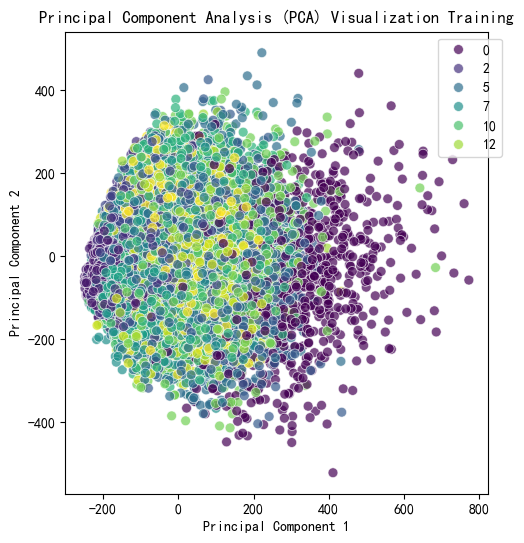

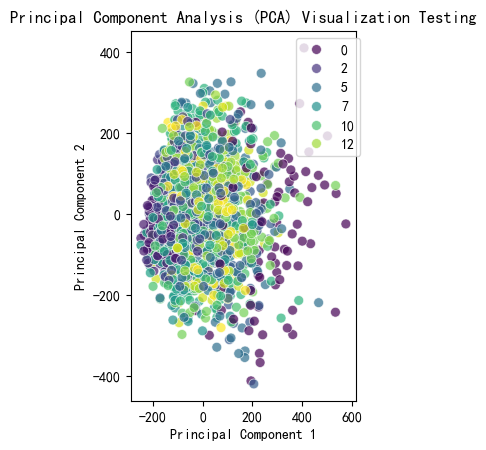

<Figure size 640x480 with 0 Axes>

In [29]:

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import os


def load_and_flatten_images(dataset):
  flattened_images = []
  labels = []

  for i in range(len(dataset)):
    img, label = dataset[i]
    img_np = img.numpy().flatten()
    flattened_images.append(img_np)
    labels.append(label)

  return np.array(flattened_images), np.array(labels)

train_flattened_images, labels = load_and_flatten_images(trainDataset)
test_flattened_images, _ = load_and_flatten_images(testDataset)

pca = PCA(n_components=2)
train_principal_components = pca.fit_transform(train_flattened_images)
test_principal_components = pca.transform(test_flattened_images)

train_pca_df = pd.DataFrame({
    'PC1': train_principal_components[:, 0],
    'PC2': train_principal_components[:, 1],
    'Label': train_labels
})

test_pca_df = pd.DataFrame({
    'PC1': test_principal_components[:, 0],
    'PC2': test_principal_components[:, 1],
    'Label': test_labels
})


plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.scatterplot(data=train_pca_df, x='PC1', y='PC2', hue='Label', palette='viridis', s= 50, alpha = 0.7)
plt.title('Principal Component Analysis (PCA) Visualization Training')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

plt.subplot(1,2,2)
sns.scatterplot(data=test_pca_df, x='PC1', y='PC2', hue='Label', palette='viridis', s= 50, alpha = 0.7)
plt.title('Principal Component Analysis (PCA) Visualization Testing')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

plt.tight_layout()
plt.show()
